In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass



In [76]:
df = pd.read_csv("Aquifer_Petrignano.csv")


In [73]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns


In [75]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]


<a id='2.3'></a>
## Stationarity

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent



The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

(733408.0, 737606.0)

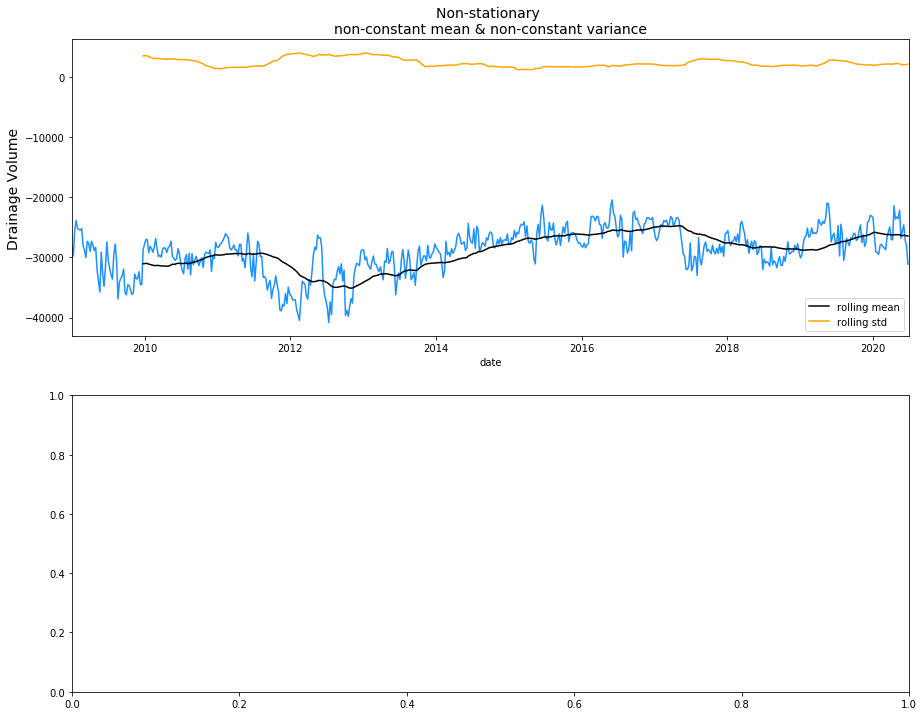

In [45]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title( 'Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])



#plt.tight_layout()
#plt.show()

In this **visual check**, we can see that the **features don't have constant mean and std**.





**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* **Null Hypothesis (H0)**: (Time series is not stationary).

* **Alternate Hypothesis (H1)**:  (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.


In [46]:

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.8802016493166605,
 0.047699190920208856,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877625)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values 

<a id='3.2'></a>
##  TimeSeries Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.


In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

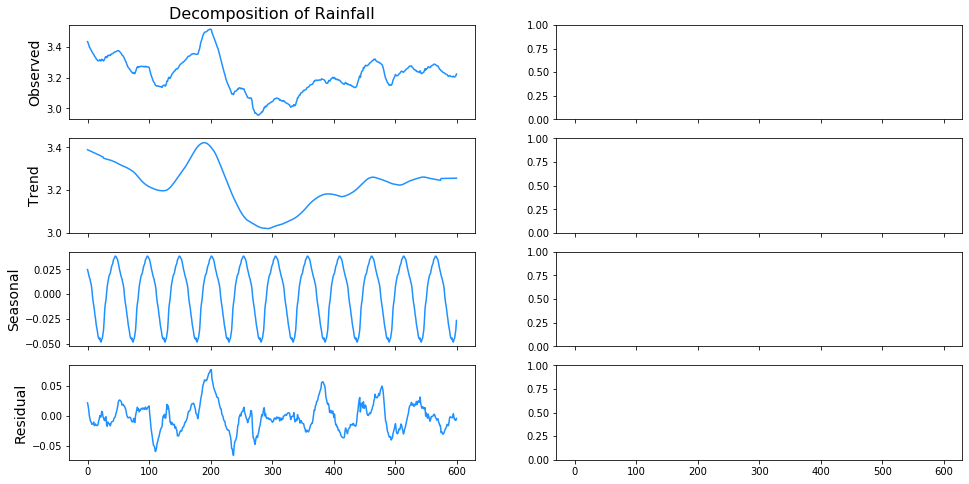

In [58]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['Rainfall']):
    
    res = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

<a id='4'></a>
# . ACF and PACF 

Now, we are going to plot the data and try to extract parameters

<a id='4.1'></a>


ACF and PACF plots: **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

<a id='5'></a>
# ARIMA Modeling 

 


The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:
* <font color='purple'>Auto-Regressive (AR) filter (long term)</font>: 
    
    $\color{purple}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{purple}p}y_{t-\color{purple}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$  -> p
* <font color='orange'> Integration filter (stochastic trend)</font>
    
    -> d
* <font color='blue'>Moving Average (MA) filter (short term)</font>:

    $\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $  -> q 


**ARIMA**: $y_t = c + \color{purple}{\alpha_1 y_{t-1} + \dots + \alpha_{\color{purple}p}y_{t-\color{purple}p}} + \color{blue}{\epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}}$


ARIMA(
<font color='purple'>p</font>,
<font color='orange'>d</font>,
<font color='blue'>q</font>)

* <font color='purple'>p</font>: Lag order (reference  PACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))
* <font color='orange'>d</font>: Degree of differencing. (reference  Differencing in [Stationarity](#2.3-Stationarity))
* <font color='blue'>q</font>: Order of moving average (check out ACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))

### Steps to analyze ARIMA

* **Step 1 — Check stationarity**: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
* **Step 2 — Difference**: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* **Step 3 — Filter out a validation sample**: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* **Step 4 — Select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 5 — Build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 6 — Validate model**: Compare the predicted values to the actuals in the validation sample.

<a id='5.1.3'></a>
##  Auto-ARIMA

In [ ]:
!pip install pmdarima

In [65]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]          

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (1,1,1) is the best configuration for (p,d,q).

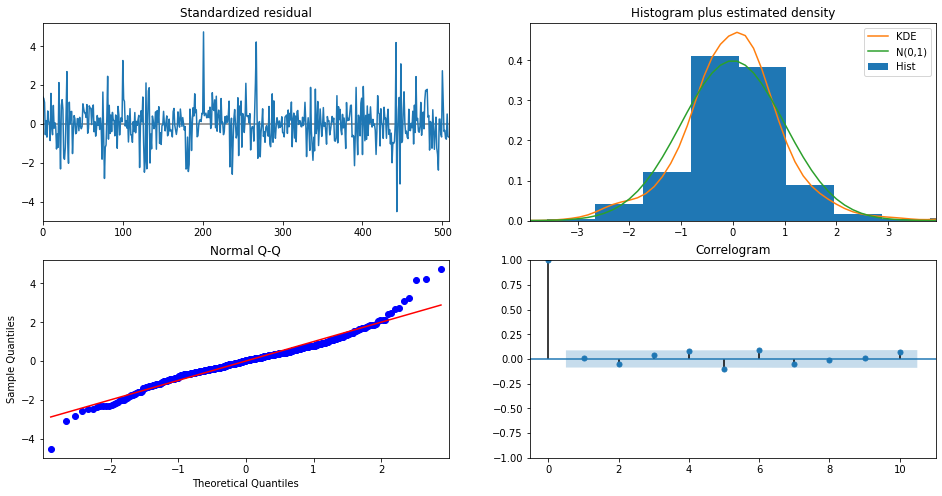

In [66]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

* **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

* **Top Right**: The density plot suggest normal distribution with mean zero.

* **Bottom left**: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

* **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.